In [7]:
# Imports
import pandas as pd
import numpy as np
from utils.data import getClassifierData
from utils.reporter import ModelEvaluationHarness
from utils.descretizer import discretize

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.ensemble import RandomForestClassifier as Classifier


In [86]:
def getTargetData(columns: list):
    cleanData = pd.DataFrame(columns=columns)
    rawData = pd.read_csv('./queryResults/target_data.csv')
    rawData.columns = [col.lower() for col in rawData.columns]
    
    columnsToDrop = ['flightnum','tailnum','taxiout', 'taxiin', 'crsarrtime']
    rawData = rawData.drop(columns=columnsToDrop)
    
    discretizeFeatures = {
            'distance': ['brief','short','middling','long'],
        }
    rawData = discretize(rawData, discretizeFeatures)
    
    oneHotCols = ['dest', 'origin', 'uniquecarrier', 'distance', 'dayofweek']
    rawData = pd.get_dummies(rawData, columns=[col for col in oneHotCols if col in rawData.columns], drop_first=True)

    cleanData = pd.concat([rawData, cleanData])
    
    cleanData = cleanData.fillna(False)
    cleanData = cleanData[columns]

    return cleanData

In [87]:
data, targets = getClassifierData()
targetData = getTargetData(data.columns)
print(targetData.head().to_markdown())

|    |   dayofmonth |   deptime |   crsdeptime |   actualelapsedtime |   crselapsedtime | dest_ABI   | dest_ABQ   | dest_ABY   | dest_ACK   | dest_ACT   | dest_ACV   | dest_ACY   | dest_ADK   | dest_ADQ   | dest_AEX   | dest_AGS   | dest_AKN   | dest_ALB   | dest_ALO   | dest_AMA   | dest_ANC   | dest_APF   | dest_ASE   | dest_ATL   | dest_ATW   | dest_AUS   | dest_AVL   | dest_AVP   | dest_AZO   | dest_BDL   | dest_BET   | dest_BFL   | dest_BGM   | dest_BGR   | dest_BHM   | dest_BIL   | dest_BIS   | dest_BLI   | dest_BMI   | dest_BNA   | dest_BOI   | dest_BOS   | dest_BPT   | dest_BQK   | dest_BQN   | dest_BRO   | dest_BRW   | dest_BTM   | dest_BTR   | dest_BTV   | dest_BUF   | dest_BUR   | dest_BWI   | dest_BZN   | dest_CAE   | dest_CAK   | dest_CDC   | dest_CDV   | dest_CEC   | dest_CHA   | dest_CHO   | dest_CHS   | dest_CIC   | dest_CID   | dest_CLD   | dest_CLE   | dest_CLL   | dest_CLT   | dest_CMH   | dest_CMI   | dest_COD   | dest_COS   | dest_CPR   | dest_CRP   | dest_CRW   | 

/var/folders/mq/kwq9hyvd6w3cxcg_djgcynpr0000gn/T/ipykernel_68011/4005758455.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleanData = cleanData.fillna(False)


In [84]:
targetData = targetData.fillna(False)

In [59]:
print(len(targetData.columns))
print(len(data.columns))

print(list(set(targetData.columns) - set(data.columns)))


644
644
[]


accuracy :
 0.6935606060606061
precision :
 0.7032321564643129
recall :
 0.6706331183577073
f1 :
 0.6865458828634751
classificationReport :
               precision    recall  f1-score   support

       False       0.68      0.72      0.70     32973
        True       0.70      0.67      0.69     33027

    accuracy                           0.69     66000
   macro avg       0.69      0.69      0.69     66000
weighted avg       0.69      0.69      0.69     66000

confusionMatrix :
 [[23626  9347]
 [10878 22149]]
roc_curve :
 {'fpr': array([0.        , 0.28347436, 1.        ]), 'tpr': array([0.        , 0.67063312, 1.        ]), 'thresholds': array([inf,  1.,  0.])}
auc :
 0.693579380274902


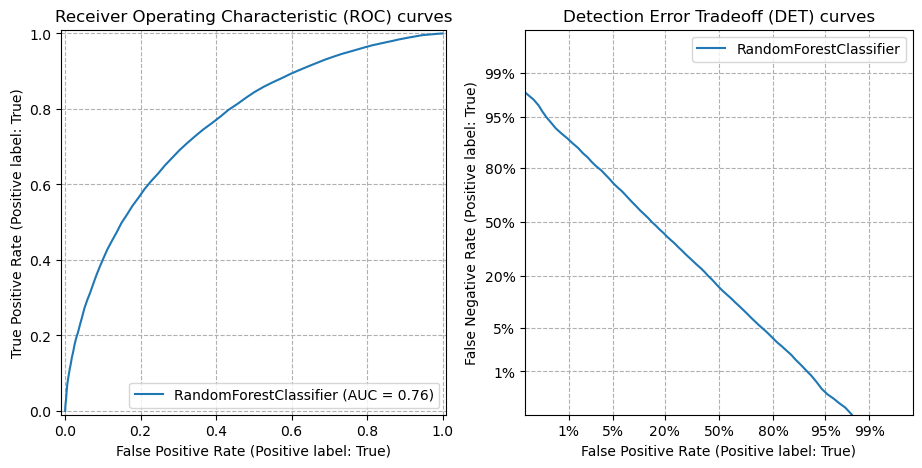

In [50]:
defaultModel = ModelEvaluationHarness(
    Classifier(),
    Classifier.__name__,
    data,
    targets
    )

defaultModel.splitData()
defaultModel.train()
defaultModel.predict()
defaultModel.evaluate()
defaultModel.graphROC()
for valuation, value in defaultModel.evaluation.items():
    print(valuation ,':\n', value)

In [90]:
# pd.DataFrame.from_dict(defaultModel.evaluation['classificationReport'])
print(defaultModel.evaluation['classificationReport'])

results = defaultModel.model.predict(targetData)

print([int(result) for result in results])

              precision    recall  f1-score   support

       False       0.68      0.72      0.70     32973
        True       0.70      0.67      0.69     33027

    accuracy                           0.69     66000
   macro avg       0.69      0.69      0.69     66000
weighted avg       0.69      0.69      0.69     66000

[0, 0, 0, 1, 0, 0, 1, 0, 0, 1]


In [ ]:
param_bounds = {
            # 'n_estimators': list(range(50, 200, 25)),
            'criterion': ['gini', 'entropy', 'log_loss'],
            # 'max_depth': [None] + list(np.arange(1,12,2)),
            # 'min_samples_split': list(np.arange(2,12,2)),
            # 'min_samples_leaf': list(np.arange(1,12,2)),
            # 'max_features': [None, 'sqrt', 'log2'] + list(np.arange(1,100,20)),
            # 'max_leaf_nodes': [None] + list(np.arange(100,500,50)),
            # 'min_weight_fraction_leaf': list(np.arange(0.0,0.5,0.1)),
        }

search = HalvingRandomSearchCV(Classifier(), param_bounds)
search = search.fit(data, targets)


"""Harness Classifier with Optimal Configuration"""
tuned_evaluator = ModelEvaluationHarness(
    Classifier(**search.best_estimator_.get_params()),
    Classifier.__name__,
    data,
    targets
)

"""Evaluate Model"""
tuned_evaluator.splitData()
tuned_evaluator.train()
tuned_evaluator.predict()
tuned_evaluator.evaluate()
tuned_evaluator.graphROC()
for valuation, value in tuned_evaluator.evaluation.items():
    print(valuation ,':\n', value)